<a href="https://colab.research.google.com/github/Gugo-le/KAIST-IT-Academy/blob/main/CNN_and_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망

# 환경설정

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

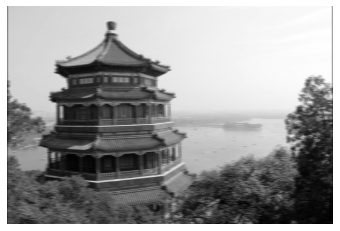

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

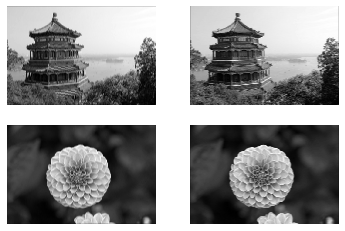

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [5]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


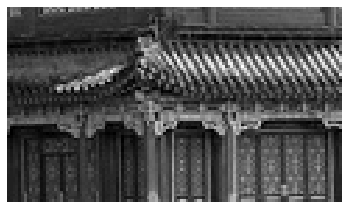

Saving figure china_vertical


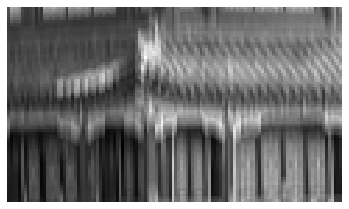

Saving figure china_horizontal


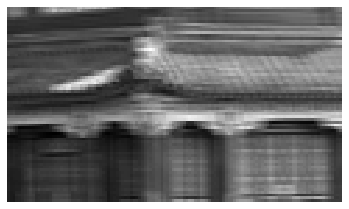

In [6]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

# 패션 MNIST 데이터 학습

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4422102/4422102 [==============================] - 0s 0us/step


In [8]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    ####
    DefaultConv2D(filters=32, kernel_size=7, input_shape=[28, 28, 1]), # input_shape는 바꾸지 않기
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(), #1차원 벡터로 변환
    keras.layers.Dense(units=128, activation='relu'), # Fully Connected 
    keras.layers.Dense(units=10, activation='softmax') # 마지막 층 폭 바꾸지 않기 (클래스 갯수)
    ####

])

In [9]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.5771 - accuracy: 0.7978 - val_loss: 0.4156 - val_accuracy: 0.8482
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3787 - accuracy: 0.8648 - val_loss: 0.3901 - val_accuracy: 0.8544
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3296 - accuracy: 0.8818 - val_loss: 0.3272 - val_accuracy: 0.8824
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3002 - accuracy: 0.8918 - val_loss: 0.3107 - val_accuracy: 0.8882
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2777 - accuracy: 0.8995 - val_loss: 0.2997 - val_accuracy: 0.8920
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2599 - accuracy: 0.9056 - val_loss: 0.2959 - val_accuracy: 0.8922
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2448 - accuracy: 0.9110 - val_loss: 0.2883 - val_accuracy

# 순환신경망

In [10]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [11]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [12]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [13]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

## 여기 있었던 내용은 삭제해주세요

In [14]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0, 0.1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)



In [15]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


# GRU

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

# RNN
# Long Short-term Memory (LSTM)
# Gated Recurrent Unit (GRU)

### 과제 부분 #################################
# 아래 GRU 모델의 예측 성능을 향상시켜보세요
# (배포 당시 test loss 기준 0.0312보다 낮게)
# - epoch 조정
# - learning rate 조정
# - 계층 추가
# - 활성화 함수 대체 -> tanh
# - 각 층의 폭 조정
# - Part 6에서 배운 내용 포함 (dropout, batch norm 등)
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]), # input_shape는 그대로 두기
    # keras.layers.GRU(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5), # 과적합을 피하기 위한 한 방법
    keras.layers.GRU(30, return_sequences=True),
    keras.layers.Dropout(rate=0.5),
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # Dense는 그대로 두기
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.007), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=30,
                    validation_data=(X_valid, Y_valid))
### 과제 부분 #################################

Epoch 1/30
219/219 [==============================] - 7s 13ms/step - loss: 0.0723 - last_time_step_mse: 0.0657 - val_loss: 0.1152 - val_last_time_step_mse: 0.1175
Epoch 2/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0467 - last_time_step_mse: 0.0372 - val_loss: 0.0893 - val_last_time_step_mse: 0.0830
Epoch 3/30
219/219 [==============================] - 2s 11ms/step - loss: 0.0408 - last_time_step_mse: 0.0298 - val_loss: 0.1122 - val_last_time_step_mse: 0.1271
Epoch 4/30
219/219 [==============================] - 2s 11ms/step - loss: 0.0387 - last_time_step_mse: 0.0271 - val_loss: 0.0589 - val_last_time_step_mse: 0.0538
Epoch 5/30
219/219 [==============================] - 2s 10ms/step - loss: 0.0361 - last_time_step_mse: 0.0243 - val_loss: 0.0265 - val_last_time_step_mse: 0.0164
Epoch 6/30
219/219 [==============================] - 2s 9ms/step - loss: 0.0351 - last_time_step_mse: 0.0228 - val_loss: 0.0311 - val_last_time_step_mse: 0.0222
Epoch 7/30
219/219 [====

In [17]:
### Test loss는 여기서 계산됩니다
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0252 - last_time_step_mse: 0.0144


[0.02516656182706356, 0.014422147534787655]

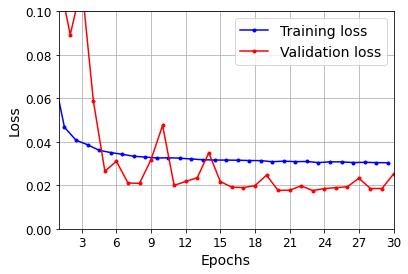

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [19]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 812ms/step


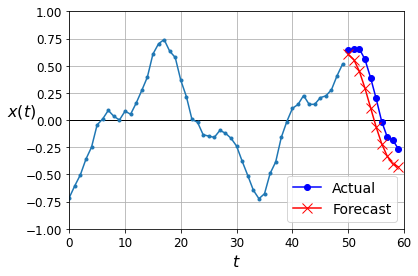

In [20]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()